In [ ]:
import re
import os.path
import matplotlib
import matplotlib.pyplot as plt
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LTTextBoxHorizontal, LAParams
from pdfminer.pdfinterp import PDFTextExtractionNotAllowed
from IPython.display import display, HTML
from pandas import DataFrame
# from adjustText import adjust_text


# 解析PDF文本，并保存到TXT文件中
def parse(pdf_path):
    TEXT = ''
    fp = open(pdf_path, 'rb')
    # 用文件对象创建一个PDF文档分析器
    parser = PDFParser(fp)
    # 创建一个PDF文档
    doc = PDFDocument()
    # 连接分析器，与文档对象
    parser.set_document(doc)
    doc.set_parser(parser)

    # 提供初始化密码，如果没有密码，就创建一个空的字符串
    doc.initialize()

    # 检测文档是否提供txt转换，不提供就忽略
    if not doc.is_extractable:
        raise PDFTextExtractionNotAllowed
    else:
        # 创建PDF，资源管理器，来共享资源
        rsrcmgr = PDFResourceManager()
        # 创建一个PDF设备对象
        laparams = LAParams()
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        # 创建一个PDF解释其对象
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # 循环遍历列表，每次处理一个page内容
        # doc.get_pages() 获取page列表
        startIndex = 0
        isEnd = False

        for page in doc.get_pages():
            interpreter.process_page(page)
            # 接受该页面的LTPage对象
            layout = device.get_result()
            # 这里layout是一个LTPage对象 里面存放着 这个page解析出的各种对象
            # 一般包括LTTextBox, LTFigure, LTImage, LTTextBoxHorizontal 等等
            # 想要获取文本就获得对象的text属性，

            for x in layout:
                if(isinstance(x, LTTextBoxHorizontal)):
                    text = x.get_text()
                    if(text.find('公司简介和主要财务指标')) > 0:
                        startIndex += 1
                    if(startIndex == 2):
                        TEXT += text

                    if(text.find('主要会计数据和财务指标')) > 0:
                        isEnd = True
            if(isEnd):
                break

    return TEXT


dir_path = os.path.abspath('.') + '\\pdf_files'
files = os.listdir(dir_path)
# print(files)

pdfList = []
for file in files:
    pdf_path = dir_path + '\\' + file
    pdfList.append(parse(pdf_path))

comInfoList = []

for pdf in pdfList:
    comInfo = {}
    r = r'(?<=股票简称)\s*[^\n]+'
    comInfo['股票简称'] = re.findall(r, pdf)[0].strip() if re.search(r, pdf) else ''

    r = r'(?<=股票代码)\s*[^\n]+'
    comInfo['股票代码'] = re.findall(r, pdf)[0].strip() if re.search(r, pdf) else ''

    r = r'(?<=公司的法定代表人)\s*[^\n]+'
    comInfo['公司的法定代表人'] = re.findall(r, pdf)[0].strip() if re.search(r, pdf) else ''

    r = r'(?<=办公地址)\s*[^\n]+'
    comInfo['办公地址'] = re.findall(r, pdf)[0].strip() if re.search(r, pdf) else ''

    r = r'(?<=公司国际互联网网址)\s*[^\n]+'
    comInfo['公司网址'] = re.findall(r, pdf)[0].strip() if re.search(r, pdf) else ''

    r = r'(?<=电子信箱)\s*[^\n]+'
    comInfo['电子信箱'] = re.findall(r, pdf)[0].strip() if re.search(r, pdf) else ''

    r = r'(?<=营业收入（元）)\s*(([^\n]+\n){4})'

    m = re.findall(r, pdf)[0]
    s = ''.join(m).replace(' ', '').split('\n')

    comInfo['2019年营业收入元'] = s[0]
    comInfo['2018年营业收入元'] = s[1]
    comInfo['2017年营业收入元'] = s[3]

    comInfoList.append(comInfo)

# print(comInfoList)
data = {'股票简称': [], '股票代码': [], '公司的法定代表人': [], '办公地址': [], '公司网址': [], '电子信箱': []}
data2 = {'股票简称': [], '股票代码': [], '2019': [], '2018': [], '2017': []}

for comInfo in comInfoList:
    data['股票简称'].append(comInfo['股票简称'])
    data['股票代码'].append(comInfo['股票代码'])
    data['公司的法定代表人'].append(comInfo['公司的法定代表人'])
    data['办公地址'].append(comInfo['办公地址'])
    data['公司网址'].append(comInfo['公司网址'])
    data['电子信箱'].append(comInfo['电子信箱'])

    data2['股票简称'].append(comInfo['股票简称'])
    data2['股票代码'].append(comInfo['股票代码'])
    data2['2019'].append(comInfo['2019年营业收入元'])
    data2['2018'].append(comInfo['2018年营业收入元'])
    data2['2017'].append(comInfo['2017年营业收入元'])

In [7]:
print('1. 提取：股票简称、股票代码、公司的法定代表人、办公地址、公司网址、电子信箱')
df = DataFrame(data)
display(HTML(df.to_html()))

1. 提取：股票简称、股票代码、公司的法定代表人、办公地址、公司网址、电子信箱


In [8]:
print('2. 提取：主要会计数据和财务指标——第01-10位：最近三年营业收入（元）')
df2 = DataFrame(data2)
display(HTML(df2.to_html()))

2. 提取：主要会计数据和财务指标——最近三年营业收入（元）


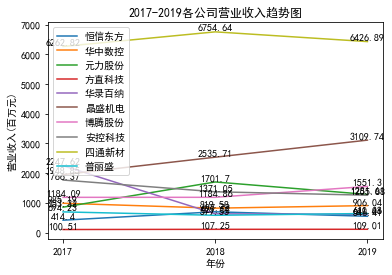

In [41]:
print('3. 所有同学，画一张或几张图，呈现一些规律')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文

x = ['2017', '2018', '2019']

# texts = []
for comInfo in comInfoList:
    y = [round(float(comInfo['2017年营业收入元'].replace(',', ''))/1000000, 2), round(float(comInfo['2018年营业收入元'].replace(',', ''))/1000000, 2), round(float(comInfo['2019年营业收入元'].replace(',', ''))/1000000, 2)]
    plt.plot(x, y, label=comInfo['股票简称'])
    for xx, yy in zip(x, y):
        plt.text(xx, yy + 1, str(yy), ha='center', va='bottom', fontsize=10)
        # texts.append(str(yy))

# new_texts = [plt.text(x_, y_, text, fontsize=10) for x_, y_, text in zip(x, y, texts)]
# adjust_text(new_texts, only_move={'text': 'x'}, arrowprops=dict(arrowstyle='-', color='grey'), save_steps=True)

plt.xlabel("年份")
plt.ylabel("营业收入(百万元)")
plt.title("2017-2019各公司营业收入趋势图")
plt.legend(loc="upper left")

plt.show()

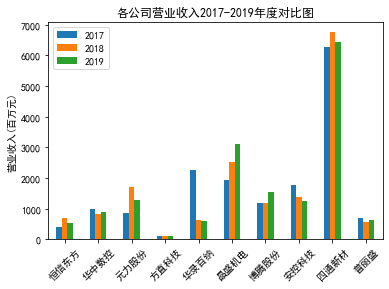

In [65]:
x = data['股票简称']
ys = []
for comInfo in comInfoList:
    y = []
    y.append(round(float(comInfo['2017年营业收入元'].replace(',', ''))/1000000, 2))
    y.append(round(float(comInfo['2018年营业收入元'].replace(',', ''))/1000000, 2))
    y.append(round(float(comInfo['2019年营业收入元'].replace(',', ''))/1000000, 2))
    ys.append(y)

chart = DataFrame(
     data=ys,
     index=x, columns=[2017, 2018, 2019])

chart.plot(kind='bar')

plt.title("各公司营业收入2017-2019年度对比图")
plt.ylabel("营业收入(百万元)")
plt.legend()
plt.xticks(rotation=45)

plt.show()

In [ ]:
#从各公司营业收入趋势图中，可以看见大部分公司的营业收入呈现上涨趋势，少部分有下降趋势，还有极少公司营业收入没有很大变化。四通新材的营业收入显著高于其他公司。晶盛机电的营业收入有明显的稳步上升。#
#从各公司营业收入三年度对比柱状图中可以看见，方直科技公司三年的营业收入变化程度极小，营业收入显著低于其他公司；四通新材公司三年的营业收入稳定在一个高位；华录百纳公司的营业收入在2018年有很明显的减少，2019年也未见回升，公司可能在2018年遇到了问题。